# Introduction to Human Activity Recognition

Here we will explore some common ways of preprocessing human activity recognition data.

Using the example data we will learn:
* how to merge multiple files into one large DataFrame
* how to split data into sliding windows
* how to quickly extract features from a window
* how to set the number of classes considered for classification
* how to build a simple Random Forest Classifier and train it on HAR data
* how to build a simple CNN and train it on HAR data 

Bear in mind that the sample data offered is not cleaned or high quality. You should not use it in your own experiments but it is useful for this tutorial.

You will need the following packages: 
* tsfresh
* scikit-learn
* tensorflow

#### Basic imports

In [5]:
import pandas as pd
import numpy as np
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Loading multiple files into one large DataFrame

At this stage you should only be working with clean data, saved in the format required for Coursework 1. An example of such data can be found in the Data/Clean/ folder.

In [9]:

base_df = pd.DataFrame()

clean_data_folder = "../pdiot-data/2022"

for each_folder in os.listdir(clean_data_folder):
    files = f"{clean_data_folder}/{each_folder}"
    print (files)
    for file in os.listdir(files):
           
        full_path = f"{files}/{file}"
        # load data into a DataFrame
        new_df = pd.read_csv(full_path)
    
        # merge into the base DataFrame
        base_df = pd.concat([base_df, new_df])

../pdiot-data/2022/s1923449
../pdiot-data/2022/s1912558
../pdiot-data/2022/s1853226
../pdiot-data/2022/s2308859
../pdiot-data/2022/s1977764
../pdiot-data/2022/s1996403
../pdiot-data/2022/s1925182
../pdiot-data/2022/s1960578
../pdiot-data/2022/s1918258
../pdiot-data/2022/s1927811
../pdiot-data/2022/s2299270
../pdiot-data/2022/s1931698
../pdiot-data/2022/s1941321
../pdiot-data/2022/s2303353
../pdiot-data/2022/s2298733
../pdiot-data/2022/s1800600
../pdiot-data/2022/s1834237
../pdiot-data/2022/s1828233
../pdiot-data/2022/s1892493
../pdiot-data/2022/s1951735
../pdiot-data/2022/s1911027
../pdiot-data/2022/s1800825
../pdiot-data/2022/s1961351
../pdiot-data/2022/s1826377
../pdiot-data/2022/s1973235
../pdiot-data/2022/s1909083
../pdiot-data/2022/s1836526
../pdiot-data/2022/s1967984
../pdiot-data/2022/s1809887
../pdiot-data/2022/s1912575
../pdiot-data/2022/s1962038
../pdiot-data/2022/s1908422
../pdiot-data/2022/s1918275
../pdiot-data/2022/s1862323
../pdiot-data/2022/s1858629
../pdiot-data/2022/s

Reset the index of the base DataFrame.

In [10]:
base_df.reset_index(drop=True, inplace=True)
base_df

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id,mag_x,mag_y,mag_z
0,1.664376e+12,-0.044189,-0.885071,-0.026917,7.343750,-7.156250,-2.218750,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN
1,1.664376e+12,-0.052246,-0.939514,-0.042786,8.656250,-5.453125,-0.453125,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN
2,1.664376e+12,-0.062500,-0.963684,0.023132,6.421875,-8.500000,-0.843750,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN
3,1.664376e+12,-0.086182,-0.947083,0.032654,3.359375,-7.546875,-0.687500,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN
4,1.664376e+12,-0.084229,-0.916565,0.023865,3.921875,-6.968750,-1.031250,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637262,1.664812e+12,-0.072754,-2.000000,-0.014709,-7.421875,-25.406250,-16.140625,Respeck,Running,11,s1957945,NaN,Respeck_s1957945_Running_03-10-2022_16-40-34,NaN,NaN,NaN
1637263,1.664812e+12,0.147949,-2.000000,0.122009,7.062500,-52.468750,-36.484375,Respeck,Running,11,s1957945,NaN,Respeck_s1957945_Running_03-10-2022_16-40-34,NaN,NaN,NaN
1637264,1.664812e+12,0.264160,-0.744690,0.152283,21.953125,-52.546875,-26.609375,Respeck,Running,11,s1957945,NaN,Respeck_s1957945_Running_03-10-2022_16-40-34,NaN,NaN,NaN
1637265,1.664812e+12,0.248047,0.275330,-0.273254,-38.968750,-75.468750,-27.953125,Respeck,Running,11,s1957945,NaN,Respeck_s1957945_Running_03-10-2022_16-40-34,NaN,NaN,NaN


Now you can get a list of all recording ids, activities, sensor types and anything else you might need.

In [11]:
print(f"The data was collected using the sensors: {base_df.sensor_type.unique()}")
print(f"The data was collected for the activities: {base_df.activity_type.unique()}")
print(f"The number of unique recordings is: {len(base_df.recording_id.unique())}")
print(f"The subject IDs in the recordings are: {len(base_df.subject_id.unique())}")

The data was collected using the sensors: ['Respeck' 'Thingy']
The data was collected for the activities: ['Walking at normal speed' 'Lying down on back' 'Sitting bent forward'
 'Sitting' 'Descending stairs' 'Standing' 'Movement' 'Running'
 'Climbing stairs' 'Lying down on stomach' 'Lying down right' 'Desk work'
 'Lying down left' 'Sitting bent backward']
The number of unique recordings is: 2156
The subject IDs in the recordings are: 78


You can of course change the clean data folder to where you keep all the PDIoT data and you should be seeing a lot more subject IDs, unique recordings and activity types.

## Splitting data into sliding windows

The sliding window approach is one of the most efficient ways to process Human Activity Recognition data. We saw in the last notebook that sensor data comes in the form of Time Series. One single datapoint is not enough to represent an activity, we need a larger snapshot of the signal for that. The image below shows how a sliding window achieves that. 

![sliding windows](../Images/sliding_windows_complete.png "Sliding Windows")

The windows can have some amount of overlap, as shown in the picture, or they can have no overlap at all in which case they would be side-by-side.

Each window can now be treated as an input datapoint to whichever model you choose to train. 

### Watch out for separate recordings

You need to make sure that when you split your data into sliding windows you don't accidentally include two separate recordings in the same window. This would cause the signal from the first recording to suddenly "jump" to an unrelated value from the second recording. 

For this, you will have to first split up your dataset by recording (this is where the recording ID comes in), then you have to split each recording into sliding windows. At the end you can aggregate all of your resulting sliding windows in a large dataset.

### Sliding windows with Pandas 

Pandas conveniently offers built-in functions that help us create the sliding window data very easily.

In [12]:
example_recording = base_df[base_df.activity_code == 1]

# confim we only have one recording here
len(example_recording.recording_id.unique())

154

In [13]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

large_enough_windows = [window for window in example_recording.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]

In [14]:
# we then get the windows with the required overlap

overlapping_windows = large_enough_windows[::step_size] 

In [15]:
# then we will append a window ID to each window
for window in overlapping_windows:
    window.loc[:, 'window_id'] = window_number
    window_number += 1

In [16]:
# now we concatenate all the resulting windows
final_sliding_windows = pd.concat(overlapping_windows).reset_index(drop=True)

In [17]:
final_sliding_windows

,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,sensor_type,activity_type,activity_code,subject_id,notes,recording_id,mag_x,mag_y,mag_z,window_id
0,1.664376e+12,-0.044189,-0.885071,-0.026917,7.343750,-7.156250,-2.218750,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN,0
1,1.664376e+12,-0.052246,-0.939514,-0.042786,8.656250,-5.453125,-0.453125,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN,0
2,1.664376e+12,-0.062500,-0.963684,0.023132,6.421875,-8.500000,-0.843750,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN,0
3,1.664376e+12,-0.086182,-0.947083,0.032654,3.359375,-7.546875,-0.687500,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN,0
4,1.664376e+12,-0.084229,-0.916565,0.023865,3.921875,-6.968750,-1.031250,Respeck,Walking at normal speed,1,s1923449,NaN,Respeck_s1923449_Walking at normal speed_28-09...,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233945,1.664811e+12,-0.030273,-1.120667,0.241882,-9.875000,7.140625,3.843750,Respeck,Walking at normal speed,1,s1957945,NaN,Respeck_s1957945_Walking at normal speed_03-10...,NaN,NaN,NaN,4678
233946,1.664811e+12,0.028320,-0.952454,0.352478,8.781250,0.875000,3.625000,Respeck,Walking at normal speed,1,s1957945,NaN,Respeck_s1957945_Walking at normal speed_03-10...,NaN,NaN,NaN,4678
233947,1.664811e+12,-0.024170,-0.785217,0.294373,14.765625,0.359375,5.687500,Respeck,Walking at normal speed,1,s1957945,NaN,Respeck_s1957945_Walking at normal speed_03-10...,NaN,NaN,NaN,4678
233948,1.664811e+12,-0.132080,-0.772034,0.225037,10.406250,-9.484375,5.625000,Respeck,Walking at normal speed,1,s1957945,NaN,Respeck_s1957945_Walking at normal speed_03-10...,NaN,NaN,NaN,4678


You can plot each window to see the signals. Here we will plot the first four windows of the walking activity.

In [21]:
first_four_windows = [group for _, group in final_sliding_windows[final_sliding_windows.window_id < 4].groupby("window_id")]

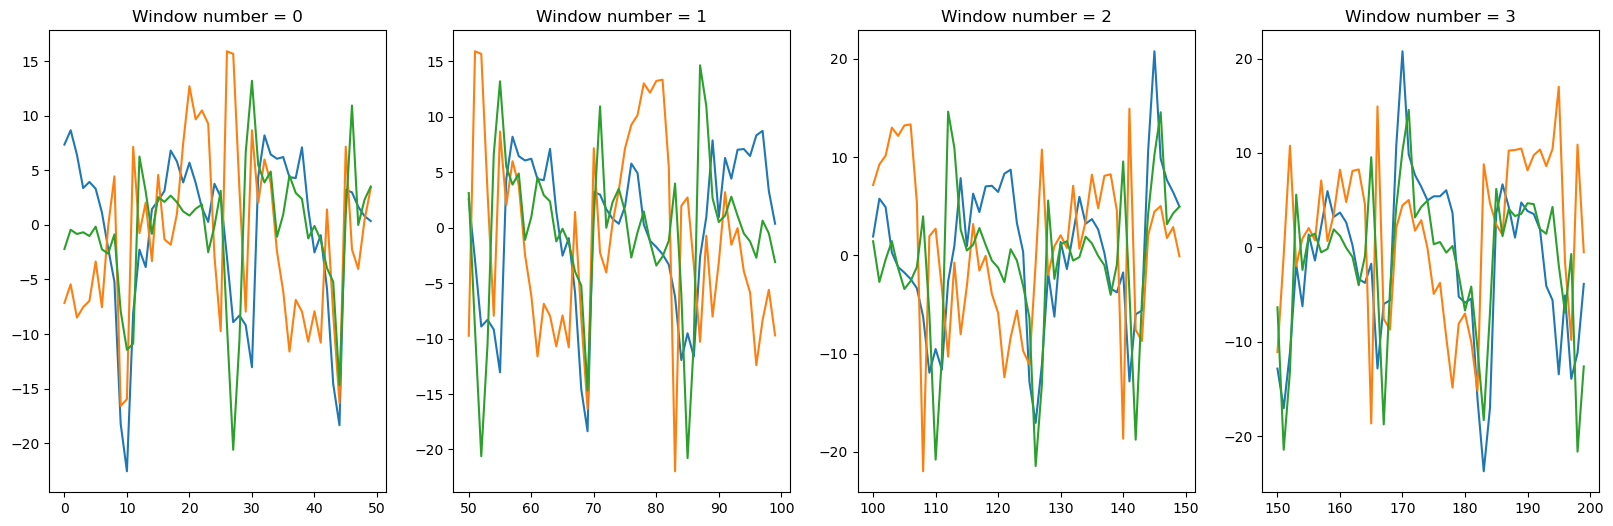

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

for i in range(4):
    ax[i].plot(first_four_windows[i]['gyro_x'])
    ax[i].plot(first_four_windows[i]['gyro_y'])
    ax[i].plot(first_four_windows[i]['gyro_z'])
    ax[i].set_title(f"Window number = {first_four_windows[i].window_id.values[0]}")


It's also interesting to observe the dimensionality of one window. Considering just the accelerometer and gyroscope signals, with all three axes, the resulting dimensionality of one window is:

In [23]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [24]:
np.array(first_four_windows[0][columns_of_interest]).shape

(50, 6)

## From sliding windows to datapoints

Each sliding window needs to be further processed in order to represent an appropriate input datapoint. The preprocessing methods might differ depending on which type of model you choose to use. 

You can also do further processing on the signal types and axes, for example smooth the signal, apply axis fusion, eliminate noise etc. 

Here we will discuss simple examples without any preprocessing. 

### Feature extraction with tsfresh

One quick and simple method to consider for HAR is a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It can take a multi-dimensional datapoint as input and can output a classification. 

We can transform each window of data into one single, multidimensional datapoint by applying simple computations using the [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html) package.

In [25]:
feature_list = []

for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    
    feature_list.append(new_features)
    
feature_list = pd.concat(feature_list, axis=1)

feature_list

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 50.75it/s]


,accel_x__sum_values,accel_x__median,accel_x__mean,accel_x__length,accel_x__standard_deviation,accel_x__variance,accel_x__root_mean_square,accel_x__maximum,accel_x__minimum,accel_y__sum_values,...,gyro_y__minimum,gyro_z__sum_values,gyro_z__median,gyro_z__mean,gyro_z__length,gyro_z__standard_deviation,gyro_z__variance,gyro_z__root_mean_square,gyro_z__maximum,gyro_z__minimum
0,-0.422852,-0.027588,-0.008457,50.0,0.133998,0.017956,0.134265,0.387939,-0.367432,-50.015991,...,-16.593750,-23.484375,-0.062500,-0.469687,50.0,5.933225,35.203158,5.951787,13.187500,-20.609375
1,-0.365479,-0.005249,-0.007310,50.0,0.140565,0.019759,0.140755,0.309082,-0.367432,-49.590942,...,-21.968750,-18.390625,0.242188,-0.367812,50.0,6.841824,46.810559,6.851704,14.625000,-20.781250
2,-0.324463,-0.020020,-0.006489,50.0,0.132175,0.017470,0.132334,0.426514,-0.334717,-49.405640,...,-21.968750,-30.546875,-0.296875,-0.610938,50.0,7.177868,51.521790,7.203821,14.625000,-21.437500
3,-0.848145,-0.032227,-0.016963,50.0,0.142832,0.020401,0.143836,0.426514,-0.484375,-50.494019,...,-18.656250,-72.531250,0.039062,-1.450625,50.0,7.601165,57.777709,7.738347,14.562500,-21.640625
4,-1.536621,-0.032837,-0.030732,50.0,0.129519,0.016775,0.133115,0.359863,-0.484375,-49.048950,...,-19.359375,-52.765625,0.445312,-1.055313,50.0,6.134546,37.632658,6.224656,7.843750,-21.640625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4674,-4.779297,-0.108521,-0.095586,50.0,0.101038,0.010209,0.139087,0.213135,-0.246582,-46.797730,...,-14.781250,15.187500,0.539062,0.303750,50.0,4.563631,20.826730,4.573729,7.453125,-11.953125
4675,-4.676514,-0.092285,-0.093530,50.0,0.103097,0.010629,0.139201,0.213135,-0.277832,-47.789185,...,-21.468750,-21.781250,-0.789062,-0.435625,50.0,5.314619,28.245172,5.332442,11.578125,-13.187500
4676,-6.594971,-0.154419,-0.131899,50.0,0.090939,0.008270,0.160210,0.164062,-0.295166,-47.413452,...,-21.468750,9.546875,-0.171875,0.190938,50.0,5.455244,29.759690,5.458585,11.578125,-13.187500
4677,-6.491211,-0.147095,-0.129824,50.0,0.081392,0.006625,0.153229,0.115723,-0.295166,-46.274292,...,-12.843750,29.000000,0.890625,0.580000,50.0,5.156752,26.592096,5.189267,8.718750,-10.984375


Now the index represents the window ID, and each row in the DataFrame represents a multi-dimensional datapoint which we can use as input to the RFC.

You can use the window ID to refer back to the initial dataframe and get the class (activity type) for each window.

We will now process both recordings so that we have two classes for our classifier. For your own work you should only aim to perform classification on data from one sensor. 

In [26]:
window_size = 50 # 50 datapoints for the window size, which, at 25Hz, means 2 seconds
step_size = 25 # this is 50% overlap

window_number = 0 # start a counter at 0 to keep track of the window number

all_overlapping_windows = []

for rid, group in base_df.groupby("recording_id"):
    print(f"Processing rid = {rid}")
    
    large_enough_windows = [window for window in group.rolling(window=window_size, min_periods=window_size) if len(window) == window_size]
    
    overlapping_windows = large_enough_windows[::step_size] 
    
    # then we will append a window ID to each window
    for window in overlapping_windows:
        window.loc[:, 'window_id'] = window_number
        window_number += 1
    
    
    all_overlapping_windows.append(pd.concat(overlapping_windows).reset_index(drop=True))

Processing rid = C:\2022\iot\our_branch\Labs\Data\2022_A\day1\Respeck_s1810150_Standing_06-10-2022_20-49-00
Processing rid = Respeck_s1732873_Climbing stairs_04-10-2022_14-29-16
Processing rid = Respeck_s1732873_Descending stairs_04-10-2022_14-29-57
Processing rid = Respeck_s1732873_Desk work_05-10-2022_09-10-44
Processing rid = Respeck_s1732873_Lying down left_04-10-2022_14-12-42
Processing rid = Respeck_s1732873_Lying down on back_04-10-2022_14-11-56
Processing rid = Respeck_s1732873_Lying down on stomach_04-10-2022_14-14-08
Processing rid = Respeck_s1732873_Lying down right_04-10-2022_14-13-24
Processing rid = Respeck_s1732873_Movement_05-10-2022_10-08-43
Processing rid = Respeck_s1732873_Running_04-10-2022_14-32-19
Processing rid = Respeck_s1732873_Sitting bent backward_04-10-2022_14-09-25
Processing rid = Respeck_s1732873_Sitting bent forward_04-10-2022_14-08-40
Processing rid = Respeck_s1732873_Sitting_04-10-2022_14-07-59
Processing rid = Respeck_s1732873_Standing_04-10-2022_14-1

In [27]:
final_sliding_windows = pd.concat(all_overlapping_windows).reset_index(drop=True)

In [28]:
# now extract all features
feature_list = []

for col in columns_of_interest:
    new_features = tsfresh.extract_features(timeseries_container=final_sliding_windows, column_id='window_id',
                        column_value=col, default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
    
    feature_list.append(new_features)
    
feature_list = pd.concat(feature_list, axis=1)

feature_list

Feature Extraction: 100%|██████████| 40/40 [00:14<00:00,  2.79it/s]


,accel_x__sum_values,accel_x__median,accel_x__mean,accel_x__length,accel_x__standard_deviation,accel_x__variance,accel_x__root_mean_square,accel_x__maximum,accel_x__minimum,accel_y__sum_values,...,gyro_y__minimum,gyro_z__sum_values,gyro_z__median,gyro_z__mean,gyro_z__length,gyro_z__standard_deviation,gyro_z__variance,gyro_z__root_mean_square,gyro_z__maximum,gyro_z__minimum
0,-10.845703,-0.216675,-0.216914,50.0,0.010934,0.000120,0.217189,-0.190186,-0.248779,-48.698120,...,-1.281250,0.515625,-0.078125,0.010313,50.0,0.522030,0.272516,0.522132,1.359375,-1.281250
1,-10.818604,-0.216187,-0.216372,50.0,0.008302,0.000069,0.216531,-0.190186,-0.239746,-48.696411,...,-1.656250,4.562500,0.132812,0.091250,50.0,0.360790,0.130170,0.372151,1.046875,-0.687500
2,-10.489502,-0.210693,-0.209790,50.0,0.010663,0.000114,0.210061,-0.185547,-0.238525,-48.782104,...,-2.015625,17.546875,0.359375,0.350938,50.0,0.449296,0.201867,0.570109,1.390625,-0.937500
3,-10.311279,-0.206665,-0.206226,50.0,0.010581,0.000112,0.206497,-0.185547,-0.238525,-48.825561,...,-2.015625,3.859375,0.078125,0.077188,50.0,0.621501,0.386264,0.626276,1.390625,-1.234375
4,-10.548584,-0.211182,-0.210972,50.0,0.007953,0.000063,0.211122,-0.190186,-0.225586,-48.705688,...,-1.875000,-8.687500,-0.140625,-0.173750,50.0,0.367990,0.135416,0.406947,0.625000,-1.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62647,-46.262695,-0.854004,-0.925254,50.0,0.412701,0.170322,1.013122,-0.155273,-2.000000,-20.803711,...,-138.718750,-131.500000,-10.296875,-2.630000,50.0,41.732476,1741.599584,41.815266,57.531250,-106.812500
62648,-45.315430,-0.844727,-0.906309,50.0,0.424313,0.180042,1.000718,-0.144531,-2.000000,-20.762695,...,-138.656250,-113.781250,-3.062500,-2.275625,50.0,42.033507,1766.815730,42.095061,58.875000,-106.812500
62649,-45.810547,-0.851074,-0.916211,50.0,0.407624,0.166157,1.002796,-0.144531,-2.000000,-19.991211,...,-138.656250,-57.437500,7.031250,-1.148750,50.0,40.105461,1608.447991,40.121909,58.875000,-103.343750
62650,-47.112305,-0.860352,-0.942246,50.0,0.393781,0.155063,1.021220,-0.305664,-1.714844,-20.725586,...,-127.968750,-19.750000,4.812500,-0.395000,50.0,40.741633,1659.880655,40.743548,61.281250,-82.593750


Now we also extract the classes from each window

In [29]:
final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min)

,activity_type
window_id,
0,Standing
1,Standing
2,Standing
3,Standing
4,Standing
...,...
62647,Walking at normal speed
62648,Walking at normal speed
62649,Walking at normal speed


We need to assign a number to each categorical class for the Random Forest Classifer. It is mainly up to you how you categorise your classes. In this example, we will use the labels:
- 0 for Desk work
- 1 for Walking at normal speed

Bear in mind that your classification task will be multi-class, not binary. 

In [42]:
class_labels = {
    'Desk work': 0,
    'Walking at normal speed': 1,
    'Standing': 2 ,
    'Sitting bent forward': 3,
    'Sitting': 4,
    'Sitting bent backward': 5,
    'Lying down right': 6,
    'Lying down left':7 ,
    'Lying down on back':8 ,
    'Lying down on stomach': 9, 
    'Movement': 10, 
    'Running': 11, 
    'Climbing stairs':12,
    'Descending stairs': 13
}

In [43]:
window_id_class_labels = final_sliding_windows.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)
window_id_class_labels

,activity_type
window_id,
0,2
1,2
2,2
3,2
4,2
...,...
62647,1
62648,1
62649,1


### Quickly training a Random Forest Classifier

We now have all the tools to start training a Random Forest Classifier. We will use the feature_list as inputs and window_id_class_labels as outputs. We will do a basic 80/20 split of the data for demonstration purposes. 

In your project you should split the data into training and tests sets by excluding entire subjects from the training set. This is discussed later on in this notebook.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(feature_list, window_id_class_labels,
                                                    test_size=0.2, train_size=0.8)

In [60]:
print(f"Training set: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set: X_test = {X_test.shape}, y_test = {y_test.shape}")

Training set: X_train = (50121, 54), y_train = (50121, 1)
Test set: X_test = (12531, 54), y_test = (12531, 1)


Now we can build and train the random forest classifier

In [61]:
rfc = RandomForestClassifier(n_estimators=10)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

/Users/ascarshen/opt/anaconda3/envs/pdiot/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       861
           1       0.87      0.95      0.91       844
           2       0.97      0.98      0.97       905
           3       0.98      0.98      0.98       868
           4       0.98      0.95      0.96       909
           5       0.98      0.98      0.98       881
           6       1.00      1.00      1.00       942
           7       1.00      0.99      0.99       898
           8       0.99      0.99      0.99       956
           9       1.00      1.00      1.00       922
          10       0.87      0.85      0.86       899
          11       0.98      0.99      0.99       892
          12       0.91      0.88      0.89       879
          13       0.91      0.87      0.89       875

    accuracy                           0.95     12531
   macro avg       0.95      0.95      0.95     12531
weighted avg       0.95      0.95      0.95     12531



This is a very easy problem so the classifier learns very quickly. Your actual problem of classifying multiple activities will be much harder.

## Leave-one-subject-out cross-validation

One of the other reason our previous classifier functions so well is that each person performs activities in a very consistent manner. If a subject's data is both in the training set and the test set, it provides the model with an unfair advantage. Moreover, the results that your model will output will be falsely high. When you test your model on a completely new, unseen subject, your accuracy will drop considerably. 

This is why when training a HAR model you will want to do a special kind of cross-validation: Leave-One-Subject-Out (LOSOXV), where we leave one (or more) subject(s) in the testing set at each iteration.

![losoxv](../Images/LOOCV.png "losoxv")

This ensures that the results we get from our classifier are consistent to what we would get in real life, if we were to test the model on a new user.

## Training a simple CNN

There are some different preprocessing techniques you can apply when the resulting "datapoint" is an input to a convolutional neural network. 

You can use two types of convolutional layers:
* 1D Conv Layers - which will work on 1D data, for example a single axis from one single sensor (accel, gyro or mag)
* 2D Conv Layers - suitable if the input data is in the form of an image, for example

We will be demonstrating how to build a simple 1D CNN using 6 channels: the 3 axes of the accelerometer and the 3 axes of the gyroscope.

### Setting up the model

In [63]:
filters = 64
kernel_size = 3
n_features = 6
activation='relu'
n_classes = 14

In [64]:
model = Sequential()

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                 input_shape=(window_size, n_features)))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
model.add(BatchNormalization())
model.add(Activation(activation))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 48, 64)            1216      
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 64)            256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 64)            256       
_________________________________________________________________
activation_7 (Activation)    (None, 46, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 44, 64)           

### Re-generating the data in the appropriate format

We need to do a bit more work with our data to bring it into a format fit for training a CNN. 

A CNN will take multi-dimensional arrays as input. We have already specified that the input shape is (window_size, n_features), i.e. (50, 6). 

Remember that we generated sliding windows before. Now we just need to take the raw values from each window and create a training set. 

In [65]:
columns_of_interest

['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [66]:
X = []
y = []

for window_id, group in final_sliding_windows.groupby('window_id'):
    print(f"window_id = {window_id}")
    
    shape = group[columns_of_interest].values.shape
    print(f"shape = {shape}")
    
    X.append(group[columns_of_interest].values)
    y.append(class_labels[group["activity_type"].values[0]])

window_id = 0
shape = (50, 6)
window_id = 1
shape = (50, 6)
window_id = 2
shape = (50, 6)
window_id = 3
shape = (50, 6)
window_id = 4
shape = (50, 6)
window_id = 5
shape = (50, 6)
window_id = 6
shape = (50, 6)
window_id = 7
shape = (50, 6)
window_id = 8
shape = (50, 6)
window_id = 9
shape = (50, 6)
window_id = 10
shape = (50, 6)
window_id = 11
shape = (50, 6)
window_id = 12
shape = (50, 6)
window_id = 13
shape = (50, 6)
window_id = 14
shape = (50, 6)
window_id = 15
shape = (50, 6)
window_id = 16
shape = (50, 6)
window_id = 17
shape = (50, 6)
window_id = 18
shape = (50, 6)
window_id = 19
shape = (50, 6)
window_id = 20
shape = (50, 6)
window_id = 21
shape = (50, 6)
window_id = 22
shape = (50, 6)
window_id = 23
shape = (50, 6)
window_id = 24
shape = (50, 6)
window_id = 25
shape = (50, 6)
window_id = 26
shape = (50, 6)
window_id = 27
shape = (50, 6)
window_id = 28
shape = (50, 6)
window_id = 29
shape = (50, 6)
window_id = 30
shape = (50, 6)
window_id = 31
shape = (50, 6)
window_id = 32
sha

In [67]:
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (62652, 50, 6)
y shape = (62652,)


We can do a similar test/train split for demonstration purposes. Remember that you will have to split your data by subjects, not radomly.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, train_size=0.8)

y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)

In [69]:
print(f"X_train shape = {X_train.shape}")
print(f"y_train shape = {y_train.shape}")

print(f"X_test shape = {X_test.shape}")
print(f"y_test shape = {y_test.shape}")

X_train shape = (50121, 50, 6)
y_train shape = (50121, 14)
X_test shape = (12531, 50, 6)
y_test shape = (12531, 14)


Now we are ready to start the training process

In [70]:
model.compile(
    optimizer=optimizers.SGD(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [71]:
model.fit(X_train, y_train,
        batch_size=2, epochs=10)

Train on 50121 samples
Epoch 1/10
50121/50121 [==============================] - 307s 6ms/sample - loss: 0.2376 - accuracy: 0.9287
Epoch 2/10
50121/50121 [==============================] - 307s 6ms/sample - loss: 0.2181 - accuracy: 0.9297
Epoch 3/10
50121/50121 [==============================] - 303s 6ms/sample - loss: 0.2062 - accuracy: 0.9318
Epoch 4/10
50121/50121 [==============================] - 317s 6ms/sample - loss: 0.1964 - accuracy: 0.9338
Epoch 5/10
50121/50121 [==============================] - 305s 6ms/sample - loss: 0.1889 - accuracy: 0.9352
Epoch 6/10
24734/50121 [=============>................] - ETA: 1:06:43 - loss: 0.1847 - accuracy: 0.9361

KeyboardInterrupt: 

We can now view the accuracy of our model on the test dataset.

In [60]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [61]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



## Conclusion

You are now ready to start developing your own models for HAR. There are numerous tutorials online which you can follow to build models like LSTMs, CNNs, RFCs and many others. 

You have a wide choice of ways to solve this classification model. Here are a few things to think about:

* What type of preprocessing do you want to apply to your data? Examples include:
    * smoothing the sensor axes
    * performing axis fusion
    * extracting scalograms from the signal
    * manually extracting features from the signal
    * choosing to leave out certain axes

* What type of model do you want to train?
    * simple ML model
    * deep learning model
    
* Do you want a hierarchical model or a flat model?
    * hierarchical models means you don't have to train the same type of model for each activity
    * a flat model might be faster to train and apply in real time